# Chapter 5: LSTM Anomaly Detection with Autoencoders

#### Imports

In [1]:
!pip install -qq arff2pandas

In [2]:
import os
#linalg 
import pandas as pd
import numpy as np
#plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

# split
from sklearn.model_selection import train_test_split 

#loading arff files 
from arff2pandas import a2p

# torch 
import torch
from torch import nn, optim 
import torch.nn.functional as F 

#copy
import copy
#colored print
import termcolor
from termcolor import colored

# set the size of the figures 
rcParams['figure.figsize'] = 15, 8

# setting the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

#### Fetch data

In [4]:
!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT

Downloading...
From: https://drive.google.com/uc?id=16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
To: /content/ECG5000.zip
100% 10.6M/10.6M [00:00<00:00, 64.9MB/s]


In [5]:
!unzip -qq ECG5000.zip

#### Load Data

In [6]:
with open('ECG5000_TRAIN.arff') as f:
  train = a2p.load(f)

with open('ECG5000_TEST.arff') as k:
  test = a2p.load(k)

# into a single dataframe
df = train.append(test)
df = df.sample(frac=1.0)
# rename the last column 
cols = list(df.columns)
cols[-1] = 'target'
df.columns = cols

# change the dtype of the target column 
df['target'] = df['target'].astype(int)

#### Visualize Data

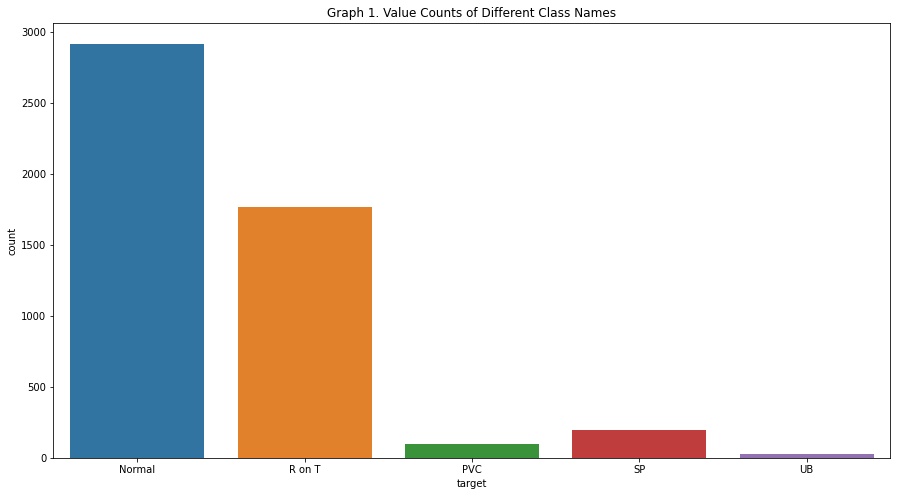

In [7]:
# some class names 
NORMAL_CLASS = 1
class_names = ['Normal','R on T', 'PVC', 'SP','UB']

# plotting 
ax = sns.countplot(x=df.target)
ax.set_xticklabels(class_names)
plt.title('Graph 1. Value Counts of Different Class Names')
plt.show()

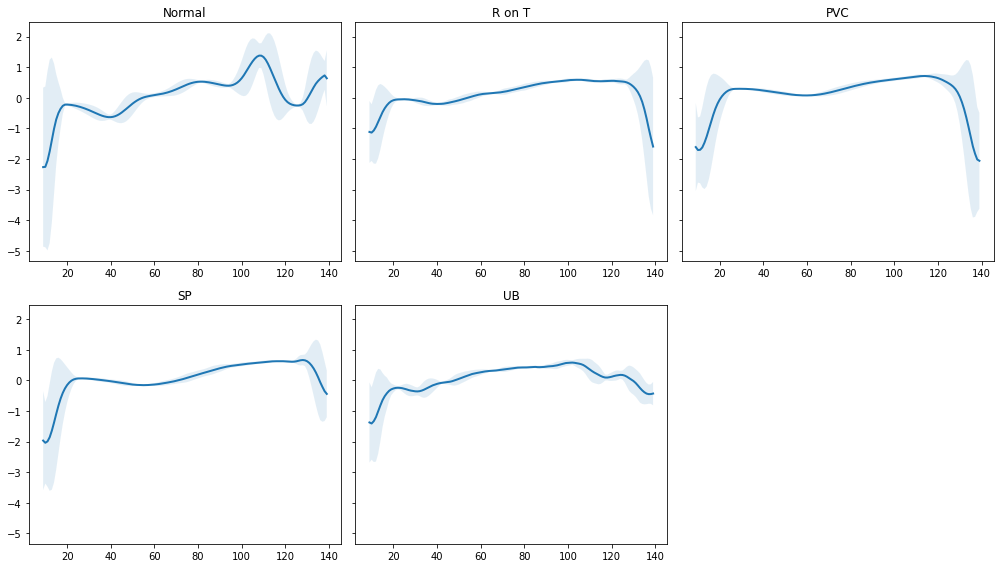

In [8]:
# from the google colab from the book 
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();
plt.show()

#### Sepparating Datasets

In [9]:
# lets sepparate the data: Normal & ¬Normal 
normal_df = df[df['target'] == NORMAL_CLASS].drop('target', axis=1)
# ¬Normal
abnormal_df = df[df['target'] != NORMAL_CLASS].drop('target', axis=1)
# showing the shapes
print("Normal and abnormal dataframes")
print(normal_df.shape, abnormal_df.shape)

# lets split the data 
# train and validation 
# 0.15 * 0.33 ≈ 5%, thus: splits = train:85%, val:10%, test:5%
df_train, df_val = train_test_split(normal_df, test_size=0.15, random_state=69)
# val and testing 
df_val, df_test = train_test_split(df_val, test_size=0.33, random_state=69)

Normal and abnormal dataframes
(2919, 140) (2081, 140)


#### Making Datasets

In [10]:
# now we need to create the datasets 
# we need to convert it into shape: 
# (sequence_length * n_features)
def make_dataset(DF,mode='train'):
  # first we need to flatten the dataframe and into a list 
  seqs = DF.astype(np.float32).to_numpy().tolist()
  # making the dataset: converting to tensors 
  # we add a dimension with unsqueeze at the 2nd position --> (141,1)
  ds = [torch.tensor(s).unsqueeze(1).float() for s in seqs]
  # we then stack these, and get their shape 
  # stacking is done similar to hstack or vstack in numpy
  n_seq, seq_len, n_features = torch.stack(ds).shape
  if mode == 'train':
    return ds, seq_len, n_features
  else:
    return ds

# we make the datasets 
# TRAINING
train_dataset, seq_len, n_features = make_dataset(df_train, mode='train')
# VALIDATION
val_dataset = make_dataset(df_val, mode='not-train')
# TESTING
test_dataset = make_dataset(df_test, mode='not-train')
# ABNORMAL DATASET
test_abnormal_ds = make_dataset(abnormal_df, mode='not-normal')

#### Making the Encoder

In [11]:
# ENCODER
class Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()
    #selfs 
    self.seq_len = seq_len
    self.n_features = n_features
    self.embedding_dim = embedding_dim
    # It is twice the embedding size because we want to 
    # expand it so it can have more dimensions
    # therefore there is more dimensions / features that can be 
    # compressed into latent variables 
    self.hidden_dim = 2 * embedding_dim

    # making the recurrent network 
    self.rnn1 = nn.LSTM(
                        input_size = n_features,
                        hidden_size = self.hidden_dim,
                        num_layers=1,
                        batch_first=True
                        )
    # the second recurrent network 
    self.rnn2 = nn.LSTM(
                      input_size = self.hidden_dim,
                      hidden_size = embedding_dim,
                      num_layers=1,
                      batch_first=True
                      )
  # forward pass
  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))
    x, (_,_) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    return hidden_n.reshape((self.n_features, self.embedding_dim))

#### Making the Decoder

In [12]:
class Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()
    self.seq_len = seq_len
    self.input_dim = input_dim
    self.hidden_dim = 2 * input_dim
    self.n_features = n_features

    # making the recurrent network 
    self.rnn1 = nn.LSTM(
                        input_size = input_dim,
                        hidden_size = input_dim,
                        num_layers=1,
                        batch_first=True
                        )
    # the second recurrent network 
    self.rnn2 = nn.LSTM(
                      input_size = input_dim,
                      hidden_size = self.hidden_dim,
                      num_layers=1,
                      batch_first=True
                      )
    # output layer 
    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  #forward pass 
  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))
    return self.output_layer(x)

#### Making the Autoencoder (Encoder + Decoder)

In [13]:
class RAE(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RAE, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  #forwards pass 
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

#### Instantiate the model

In [14]:
model_ae = RAE(seq_len, n_features, 128)
model_ae = model_ae.to(device)

In [19]:
model_ae

RAE(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

#### Training Loop

In [27]:
def training_loop(MODEL, TRAIN_DATA, VAL_DATA, DEVICE, EPOCHS):
  '''
  Helper function to train the model on the: 
  - Train dataset 
  - Validation dataset 
  for a specified number of EPOCHS

  '''
  # define the optimizer 
  opt = optim.Adam(MODEL.parameters(), lr=1e-3)
  # define our cost function 
  loss_func = nn.L1Loss(reduction='sum').to(DEVICE)
  # track the history 
  history = dict(train=[], val=[])

  # state dict 
  #best_model = copy.deepcopy(MODEL.state_dict())
  best_loss = 10000.0

  # loop 
  for epoch in range(EPOCHS):
    # set to training 
    MODEL = MODEL.train()
    # track the loss 
    train_loss = []
    for original_sequence in TRAIN_DATA:
      # zero the gradients
      opt.zero_grad()
      # send to device
      original_sequence = original_sequence.to(DEVICE)
      # predicting the sequence 
      pred_seq = MODEL(original_sequence)
      # determine the loss 
      loss = loss_func(pred_seq, original_sequence)
      # propagate 
      loss.backward()
      # step
      opt.step()
      # track the loss 
      train_loss.append(loss.item())
    # NOW WE VALIDATE
    val_losses = []
    MODEL = MODEL.eval()
    with torch.no_grad():
      for original_sequence in VAL_DATA:
        # send to d
        original_sequence = original_sequence.to(DEVICE)
        #predict 
        pred_seq = MODEL(original_sequence)
        # calculate the loss 
        val_loss = loss_func(pred_seq, original_sequence)
        # append
        val_losses.append(val_loss.item())
    # taking the average
    train_loss = np.mean(train_loss)
    val_losses = np.mean(val_losses)
    # appending to the history 
    history['train'].append(train_loss)
    history['val'].append(val_losses)
    # now keep track of the best loss 
    if val_loss < best_loss:
      best_loss = val_loss
      #best_model = copy.deepcopy(MODEL.state_dict())
    debug_txt = f"\nTRAINING --- EPOCH: {epoch} --- TRAIN LOSS: {train_loss} --- VAL LOSS: {val_losses}"
    print(colored(debug_txt, 'red','on_white'))
  # loading the best model 
  #MODEL.load_state_dict(best_model)
  return MODEL.eval(), history


#### Actual Training

In [28]:
model, history = training_loop(model_ae,
                               train_dataset,
                               val_dataset,
                               device,
                               EPOCHS=30)


TRAINING --- EPOCH: 0 --- TRAIN LOSS: 20.565458772452498 --- VAL LOSS: 18.93135979558014

TRAINING --- EPOCH: 1 --- TRAIN LOSS: 19.430236712428457 --- VAL LOSS: 18.16281157548924

TRAINING --- EPOCH: 2 --- TRAIN LOSS: 18.784084511110734 --- VAL LOSS: 19.45093519126189

TRAINING --- EPOCH: 3 --- TRAIN LOSS: 18.59398806935979 --- VAL LOSS: 16.153816123871266

TRAINING --- EPOCH: 4 --- TRAIN LOSS: 17.97936878834747 --- VAL LOSS: 15.848345710962706

TRAINING --- EPOCH: 5 --- TRAIN LOSS: 17.473653324185626 --- VAL LOSS: 16.302490787701394

TRAINING --- EPOCH: 6 --- TRAIN LOSS: 18.100933074374584 --- VAL LOSS: 21.889322668212266

TRAINING --- EPOCH: 7 --- TRAIN LOSS: 18.19583534243029 --- VAL LOSS: 15.413538888859668

TRAINING --- EPOCH: 8 --- TRAIN LOSS: 17.531168819482843 --- VAL LOSS: 14.892759201062825

TRAINING --- EPOCH: 9 --- TRAIN LOSS: 16.898734957015787 --- VAL LOSS: 21.670208556660207

TRAINING --- EPOCH: 10 --- TRAIN LOSS: 16.732507542514455 --- VAL LOSS: 14.960598153058987

TRA

#### Defining a predict function 

In [29]:
# create a function to predict 
def _predict(MODEL, DATASET):
  predictions, losses = [],[]
  loss_func = nn.L1Loss(reduction='sum').to(device)
  # test mode 
  with torch.no_grad():
    MODEL = MODEL.eval()
    for original_sequence in DATASET:
      # to d
      original_sequence = original_sequence.to(device)
      # pred 
      pred_seq = MODEL(original_sequence)
      # loss
      loss = loss_func(pred_seq, original_sequence)
      # track
      predictions.append(pred_seq.cpu().detach().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

#### Evaluation 

In [38]:
# count the number of correct predictions 
def get_correct(VALUE, LOSSES, DATASET,mode='Normal',show_graph=True):
  if show_graph:
    g = sns.distplot(LOSSES, bins=50, kde=True)
    plt.show()
  
  if mode == 'Normal':
    correct = sum(k<= VALUE for k in LOSSES)
    text = f"\nCorrect Normal Predictions --- {correct}/{len(DATASET)}"
    print(colored(text, 'green','on_white',attrs=['bold']))
  
  if mode == 'Abnormal':
    correct = sum(uu > VALUE for uu in LOSSES)
    text = f"\nCorrect Abnormal Predictions --- {correct}/{len(DATASET)}"
    print(colored(text, 'red','on_white',attrs=['bold']))

In [39]:
# lets define a threshold 
THRESHOLD = 26 # defines what is normal vs abnormal 

# lets look at the normal heartbeats 
predictions, pred_losses = _predict(model_ae, test_dataset)

# abnormal ones
# filter the abnormal dataset to match length of original 
anomaly_dataset = test_abnormal_ds[:len(test_dataset)]
ab_preds, ab_losses = _predict(model_ae,anomaly_dataset)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


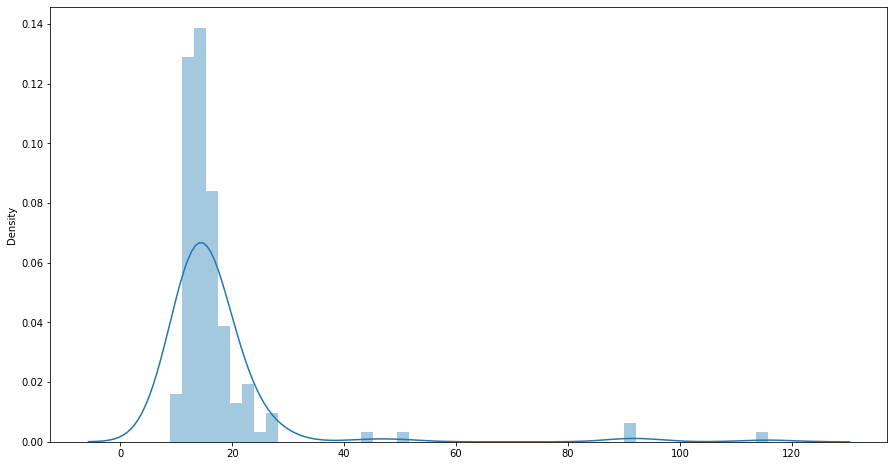


Correct Normal Predictions --- 137/145


In [40]:
# looking at the normal graphs 
get_correct(THRESHOLD, pred_losses, test_dataset ,mode='Normal',show_graph=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


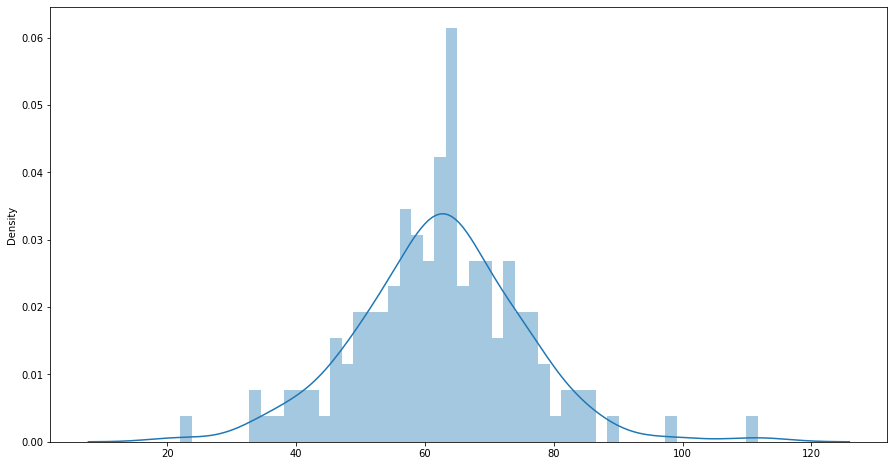


Correct Abnormal Predictions --- 144/145


In [41]:
#looking at the abnormal
get_correct(THRESHOLD, ab_losses,anomaly_dataset, mode='Abnormal',show_graph=True)

#### Looking at more examples

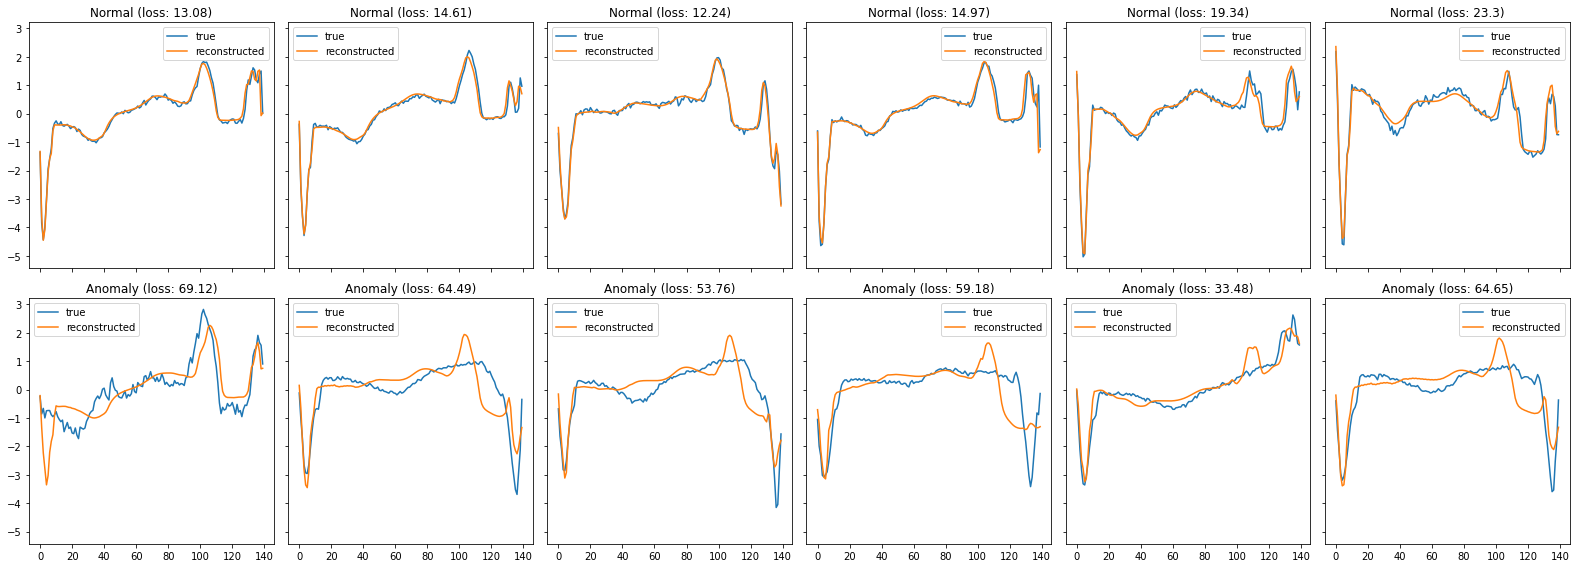

In [42]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = _predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_dataset[:6]):
  plot_prediction(data, model_ae, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_abnormal_ds[:6]):
  plot_prediction(data, model_ae, title='Anomaly', ax=axs[1, i])

fig.tight_layout();